<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Notebook_attacco_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import librerie**

##Import ART

In [ ]:
#importa ART
!pip install adversarial-robustness-toolbox

##Librerie

In [ ]:
#Librerie
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras import layers,models,losses,optimizers,applications
import numpy as np
from art.utils import load_dataset
import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow

# **Dataset**

##Load dataset stl10

In [ ]:
(x_train, y_train), (x_test_tot, y_test_tot), min_, max_ = load_dataset(str("stl10")) #carica train e test set

##Riduzione training set

In [ ]:
x_test, y_test = x_test_tot[:500], y_test_tot[:500]

##Stampa dimensioni

In [ ]:
im_shape = x_train[0].shape
print("dimensioni immagine: ",im_shape)
print("dimensioni train set: ",x_train.shape)
print("dimensioni vettore classi reali: ",y_train.shape)
print("dimensioni test set: ",x_test.shape)

dimensioni immagine:  (96, 96, 3)
dimensioni train set:  (5000, 96, 96, 3)
dimensioni vettore classi reali:  (5000, 10)
dimensioni test set:  (500, 96, 96, 3)


#**Creazione modello**

## Caricamento modello da drive

In [ ]:
#def variabili
model_save_name = 'model_DenseNet201'
path_model_save = F"/content/gdrive/My Drive/ModelliCNN/{model_save_name}" 

#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

#load model
model= tf.keras.models.load_model(path_model_save)

Mounted at /content/gdrive


##Creazione classificatore ART

In [ ]:
from art.estimators.classification import KerasClassifier
#creazione classificatore di tipo Keras usando il modello addestrato, poiché ART supporta solo determinati classificatori
classifier = KerasClassifier(model=model, clip_values=(min_, max_)) #è un wrapper messo a disposizione da ART per creare un classificatore a partire da un modello addestrato

# **Def funzioni**

##Calcolo perturbazioni



In [ ]:
def compute_perturb(x,x_adv):
  '''
    x: img originali
    x_adv: img contraddittorie
    return: pertubazioni, media, perturbazioni normalizzate in [0,1] 
  '''
  perturb=x_adv-x
  m=np.mean(np.abs((x_adv - x)))
  print('Average perturbation: {:4.2f}'.format(m))
  min, max = np.amin(perturb), np.amax(perturb)
  perturb_norm = (perturb - min) / (max - min)
  return perturb,m,perturb_norm

##Testing

In [ ]:
def testing(x,y,classifier):
  '''
    x: img test
    y: classi reali
    classifier: modello di tipo Keras addestrato
    return: valori probabilità, classi predette, accuracy
  '''
  
  value_preds=classifier.predict(x) #contiene i valori tra 0 e 1 predetti per ognuna delle 10 classi e per ogni immagine
  preds = np.argmax(value_preds, axis=1) #(le predizioni vanno da 0 a 9 e indicano la classe predetta)
  acc = (np.sum(preds == np.argmax(y, axis=1)) / y.shape[0])*100
  print("Accuracy on test set:", (round(acc,2)))
  #print("classi predette: ",preds)
  return value_preds,preds,acc

##Print subplot

In [ ]:
def print_subplot(n_img,preds,value_preds_adv,x_test,y_test,x_test_adv,perturb_norm):
  '''
    n_img: prime n immagini da visualizzare
    preds: classi predette per img originali
    value_preds_adv: probabilità predette img contraddittorie
    x_test: img originali
    y_test: classi originali
    x_test_adv: img contraddittoria
    perturb_norm: perturbazioni normalizzate
  '''
  #nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
  for i in range(n_img):#(x_test.shape[0]):
    value=value_preds_adv[i]*100
    value_sorted=sorted(value,reverse=True)
    classes=[]
    for j in range(value.size) :
      ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
      classes.append(ind[0][0]) #classes è il vettore finale
    
    value_sorted=[ round(elem, 2) for elem in value_sorted ]

    #in seguito per ogni immagine del test set si stampa un subplot
    fig = plt.figure(figsize=[10,10])
    plt.subplots_adjust(wspace=0.9)
    print('\033[1m'+"IMMAGINE "+'\033[1m',i) #valore END: '\033[0m'
    #originale
    ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
    ax1.axis('off')
    ax1.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax1.title.set_text("ORIGINALE\nclasse reale: "+str(np.argmax(y_test[i]))+"\nclasse predetta: "+str(preds[i]))
    #perturbazione
    ax2 = fig.add_subplot(132)
    ax2.imshow(cv2.rotate(perturb_norm[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax2.axis('off')
    ax2.title.set_text("PERTURBAZIONE")
    #perturbata
    ax3 = fig.add_subplot(133)
    ax3.imshow(cv2.rotate(x_test_adv[i],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
    ax3.axis('off')
    ax3.title.set_text("PERTURBATA\ntop5 classi predette: "+str(classes[:5])+"\ncon valori: "+str(value_sorted[:5]))
    plt.show()

##Attacco singola immagine

In [ ]:
def perturb_img(img,real_class : int,classifier,attack):
  '''
    img: img da attaccare
    real_class: classe reale
    classifier: modello Keras addestrato
    attack: oggetto ART che implementa l'attacco
  '''
  y=np.zeros(10)
  y[real_class]=1
  y=y.reshape(1,10) #trasformo la classe in una matrice con una riga e 10 colonne

  #resize
  img=cv2.resize(img,(96,96))
  print("img originale")
  cv2_imshow(img)
  #normalizza tra [0,1]
  min, max = np.amin(img), np.amax(img)
  img = (img - min) / (max - min)
  
  #trasforma in tensore
  img=img.reshape(1,96,96,3)

  #test img originale
  value_pred,pred,acc=testing(img,y,classifier)
  print("Classe predetta: "+str(pred))

  #attacco
  img_adv=attack.generate(x=img,y=y)
  
  #calcolo perturbazione
  p,m,p_norm=compute_perturb(img,img_adv)
  
  #print perturbazione
  print("perturbazione")
  cv2_imshow(p_norm[0]*255)
  
  #print img perturbata
  print("img perturbata")
  cv2_imshow(img_adv[0]*max)

  #test img adv
  value_pred_adv,pred_adv,acc_adv=testing(img_adv,y,classifier)
  print("Classe predetta adv: "+str(pred_adv))
  

# **Esecuzione**

##Attacco

###Definizione attacco

In [ ]:
from art.attacks.evasion import FastGradientMethod
# FGM
attack = FastGradientMethod(estimator=classifier, eps=0.1)

###Generazione adversarial samples

In [ ]:
x_test_adv = attack.generate(x=x_test,y=y_test) #aggiunge una perturbazione alle immagini del test set
#N.B. si possono passare le classi reali del test set (con y=y_test) e in questo caso FGM calcolerà le perturbazioni in modo che il classificatore
#non predica queste classi. Mentre, se non passo y_test, le calcolerà in modo da non fargli predire la classe predetta normalmente (la quale può essere diversa da quella reale
#se il classificatore non è corretto)

##Calcolo perturbazione

In [ ]:
perturb,m,perturb_norm=compute_perturb(x_test,x_test_adv)

Average perturbation: 0.10


##Testing

###Testing img originali

In [ ]:
value_preds,preds,acc=testing(x_test,y_test,classifier)

Accuracy on test set: 77.0


###Testing img perturbate

In [ ]:
value_preds_adv,preds_adv,acc_adv=testing(x_test_adv,y_test,classifier)

Accuracy on test set: 5.8


##Stampa subplot prime N immagini

IMMAGINE  0


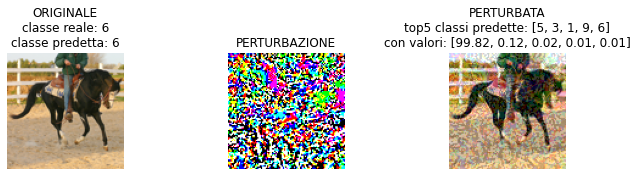

IMMAGINE  1


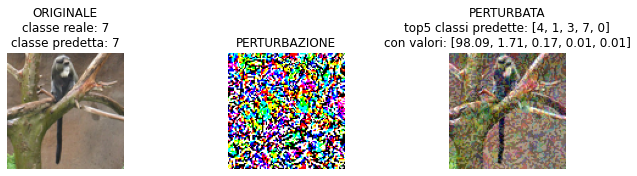

IMMAGINE  2


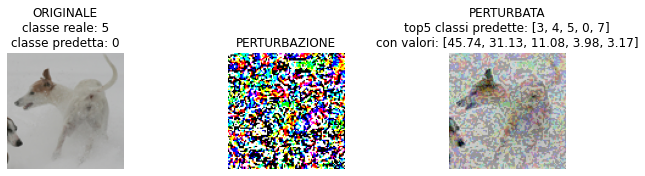

In [ ]:
print_subplot(3,preds,value_preds_adv,x_test,y_test,x_test_adv,perturb_norm)

# **Testing su singola img da drive**

img originale


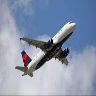

Accuracy on test set: 100.0
Classe predetta: [0]
Average perturbation: 0.10
perturbazione


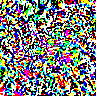

img perturbata


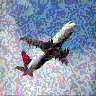

Accuracy on test set: 0.0
Classe predetta adv: [1]
img originale


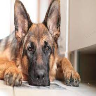

Accuracy on test set: 0.0
Classe predetta: [3]
Average perturbation: 0.10
perturbazione


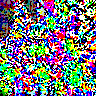

img perturbata


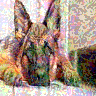

Accuracy on test set: 0.0
Classe predetta adv: [3]


In [ ]:
#immagini google
path_img_google="/content/gdrive/MyDrive/immagini_google/"

#test su immagini di google

#10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

img_g1=cv2.imread(path_img_google+"airplane.jpg")
img_g2=cv2.imread(path_img_google+"dog.jpg")

perturb_img(img_g1,0,classifier,attack)
perturb_img(img_g2,5,classifier,attack)


